In [1164]:
import cv2
import pandas as pd # for working with dataframes
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from pathlib import Path # for retrieving files from directory
import networkx as nx # for making graphs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg # for images
from scipy.interpolate import interp1d # for interpolating points
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn.decomposition import PCA # for principal component analysis
import seaborn as sns # for plotting in seaborn
import math

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def detect_pointy_tips(contour, window):
    """
    define a function to calculate how pointy each point in a contour is
    inputs: the contour and the window to define neighbors
    outputs: the angles of each contour point
    """
    pointy_tips = []
    for i in range(len(contour)):
        # Get the current point and its neighbors, defined by window
        p2 = contour[i]
        p3 = contour[(i + window) % len(contour)]
        p1 = contour[(i - window) % len(contour)]

        # Calculate the angle between the two vectors formed by the neighbors
        angle = angle_between(p1, p2, p3)

        # save current angle
        pointy_tips.append(angle)

    return pointy_tips

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean

def foo(a, start, stop): 
    # fn to convert start stop to a wrapped range
    if stop<=start:
        stop += len(a)
    return np.arange(start, stop)%len(a)

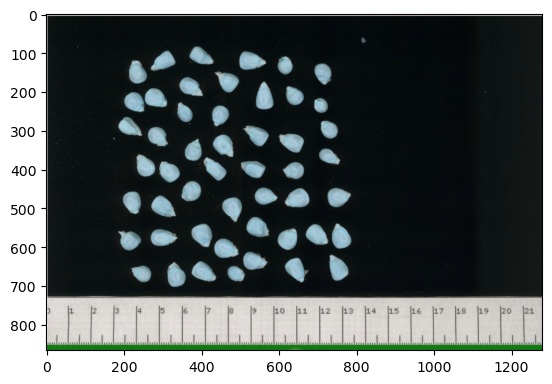

In [1168]:
# Load image and find contours
image = cv2.imread('geno1.jpeg')
plt.imshow(image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [1169]:
min_area = 500
max_area = 5000

conts = []

for i in range(len(contours)):
    if np.shape(contours[i])[0] > 3:
        con = np.reshape(contours[i], (np.shape(contours[i])[0], 2))

    if (poly_area(con[:,0], con[:,1])<max_area) & (poly_area(con[:,0], con[:,1])>min_area):
        conts.append(con)

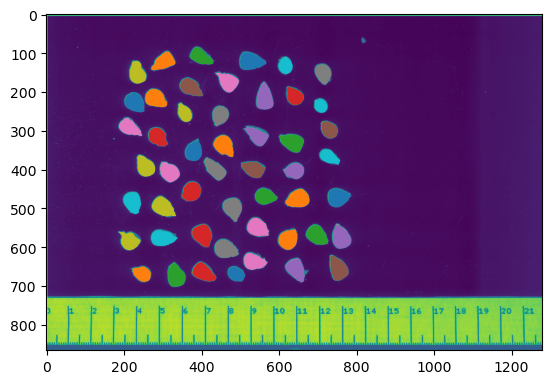

In [1170]:
plt.imshow(gray)

for i in range(len(conts)):
    plt.fill(conts[i][:,0],conts[i][:,1])

In [1171]:
from scipy.stats import zscore

In [1172]:
res = 200 # how many points to interpolate
win = 60 # window size for detecting angles

z_arr = np.zeros( (len(conts), res-1, 4))

for i in range(len(conts)): # for each contour

    # select current contour
    curr_cont = conts[i]
    
    # close the contour
    closed_arr = np.zeros((len(curr_cont)+1,2))
    closed_arr[:-1] = curr_cont
    closed_arr[-1] = curr_cont[0]
    
    # calculate interpolated contour
    interp = np.column_stack(interpolation(closed_arr[:,0], closed_arr[:,1], res)) 
    
    # remove last point of interpolation
    interp = interp[:-1]
    
    # find angles for each contour point
    angs = detect_pointy_tips(interp, win)
    ang_z = zscore(angs)

    # find distances to centroid
    cent = np.mean(interp, axis=0)

    dists = []
    for j in range(len(interp)):
        dists.append(euclid_dist(cent[0],cent[1], interp[j][0], interp[j][1]))
    dist_z = zscore(dists)
        
    # store contour, angles, dists
    z_arr[i] = np.column_stack((interp, ang_z, dist_z))

In [1173]:
subtract = z_arr[:,:,2]-z_arr[:,:,3]

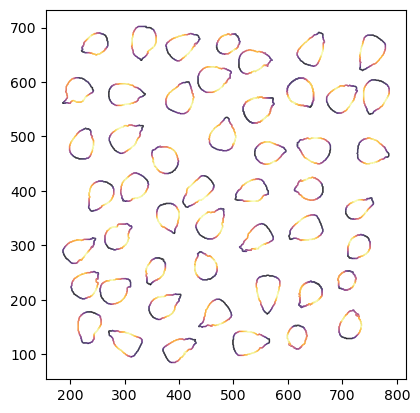

In [1174]:
#plt.imshow(image, alpha=0.5)

for i in range(len(z_arr)):
    curr_ker = z_arr[i,:,:]

    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,2], s=1, legend=False, palette="inferno_r")
    plt.gca().set_aspect("equal")

In [1175]:
thresh = 0.1 # threshold to call peaks
rwin = 10 # window for smoothing z scores

leaf_list = [] # processed leaves
landmarks = [] # indices of landmarks

for i in range(len(z_arr)): # for each kernel

    a = z_arr[i,:,2] # get current kernel angles
    smooth_ang = [] # calculate smoothened z scores angles
    for j in range(len(a)):
        rolled = np.roll(a, -j)
        roll_window = rolled[:rwin]
        smooth_ang.append(np.mean(roll_window))
    
    d = z_arr[i,:,3] # get current kernel distances
    smooth_dist = [] # calculate smoothened z scores distances
    for k in range(len(d)):
        rolled = np.roll(d, -k)
        roll_window = rolled[:rwin]
        smooth_dist.append(np.mean(roll_window))
    
    # Find intersection indices with thresholds
    positive_intersection = np.where(np.diff(np.sign(np.array(smooth_ang) - thresh)))[0]
    negative_intersection = np.where(np.diff(np.sign(np.array(smooth_ang) + thresh)))[0]
    inter = np.concatenate((negative_intersection, positive_intersection))
    inter.sort()
    
    if len(inter)!=8:
        continue
    
    # create an array of the indices
    ind_arr = np.arange(0,res-1)
    
    # find landmarks as midpoint values
    landmark_indices = [] 
    for l in range(8):
        indices = foo(ind_arr, inter[l%8], inter[(l+1)%8]+1)
        #index_list.append(inter[l%8])
        landmark_indices.append(indices[len(indices)//2])
    
    # find smooth_ang and smooth_dist values for indices
    smooth_ang_vals = [smooth_ang[i] for i in landmark_indices]
    smooth_dist_vals = [smooth_dist[i] for i in landmark_indices]
    
    # sort smooth_ang values (negative to positive)
    sorted_indices = np.argsort(smooth_ang_vals)
    
    # find the tip and base index (the index of landmark_indices that is the tip or base)
    if (smooth_ang_vals[sorted_indices[-1]]-smooth_dist_vals[sorted_indices[-1]]) > (smooth_ang_vals[sorted_indices[-2]]-smooth_dist_vals[sorted_indices[-2]]):
        tip_index = sorted_indices[-1]
        base_index = sorted_indices[-2]
    else:
        tip_index = sorted_indices[-2]
        base_index = sorted_indices[-1]
    
    # reindex landmarks starting at tip
    # TIP, BORDER, SIDE, BORDER, BASE, BORDER, SIDE, BORDER
    indices_from_tip = np.concatenate(  (landmark_indices[tip_index:],landmark_indices[:tip_index] ) )

    leaf_list.append(i)
    landmarks.append(indices_from_tip)


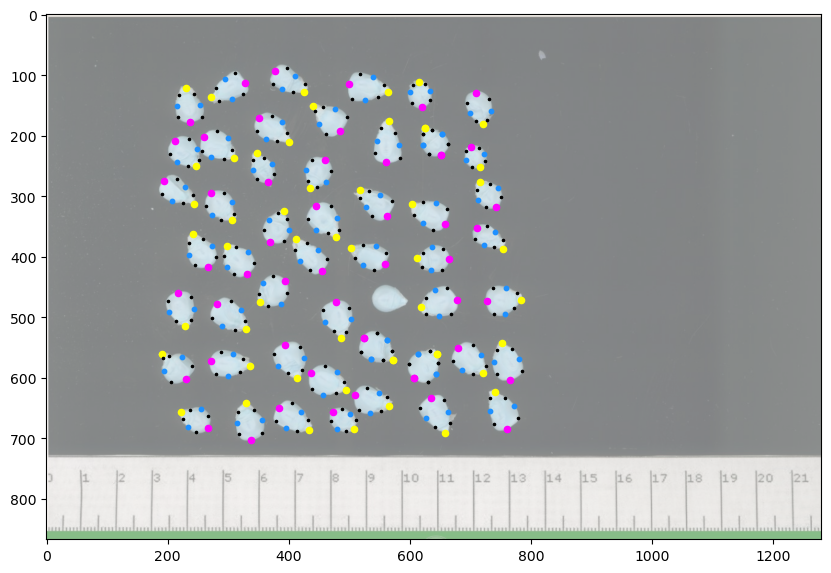

In [1176]:
pt_size=5

plt.figure(figsize=(10,10))
plt.imshow(image, alpha=0.5)

#for i in range(len(z_arr)):
#    curr_ker = z_arr[i,:,:]

#    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,2], s=1, legend=False, palette="inferno_r")
#    plt.gca().set_aspect("equal")

for j in range(len(leaf_list)):
    curr_leaf = z_arr[leaf_list[j]]
    curr_landmarks = landmarks[j]
    
    tip_index = curr_landmarks[0]
    base_index = curr_landmarks[4]
    side_index1 = curr_landmarks[2]
    side_index2 = curr_landmarks[6]
    border_index1 = curr_landmarks[1]
    border_index2 = curr_landmarks[3]
    border_index3 = curr_landmarks[5]
    border_index4 = curr_landmarks[7]

    plt.scatter(curr_leaf[tip_index][0], curr_leaf[tip_index][1], c="magenta", s=pt_size*4)
    plt.scatter(curr_leaf[base_index][0], curr_leaf[base_index][1], c="yellow", s=pt_size*4)
    plt.scatter(curr_leaf[side_index1][0], curr_leaf[side_index1][1], c="dodgerblue", s=pt_size*2)
    plt.scatter(curr_leaf[side_index2][0], curr_leaf[side_index2][1], c="dodgerblue", s=pt_size*2)

    plt.scatter(curr_leaf[border_index1][0], curr_leaf[border_index1][1], c="k", s=pt_size/2)
    plt.scatter(curr_leaf[border_index2][0], curr_leaf[border_index2][1], c="k", s=pt_size/2)
    plt.scatter(curr_leaf[border_index3][0], curr_leaf[border_index3][1], c="k", s=pt_size/2)
    plt.scatter(curr_leaf[border_index4][0], curr_leaf[border_index4][1], c="k", s=pt_size/2)


In [1099]:
landmark_indices

[22, 47, 72, 100, 128, 152, 177, 0]

In [1100]:
indices_from_tip

array([100, 128, 152, 177,   0,  22,  47,  72])

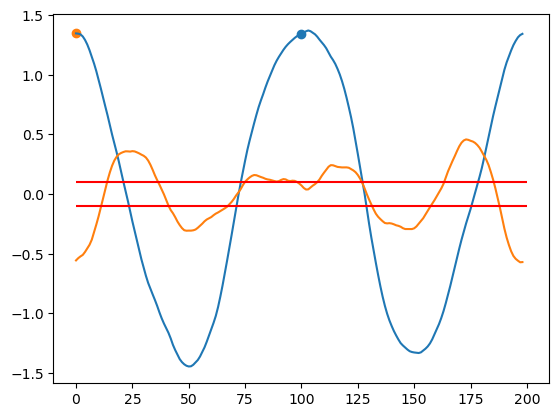

In [1101]:
ind_arr = np.arange(0,res-1)
plt.plot(ind_arr.tolist(), smooth_ang)
#plt.plot(ind_arr.tolist(), smooth_dist)
plt.plot(ind_arr.tolist(), np.array(smooth_ang)-np.array(smooth_dist))

#plt.scatter(landmark_indices, smooth_ang_vals)
plt.scatter(landmark_indices[tip_index], smooth_ang_vals[tip_index])
plt.scatter(landmark_indices[base_index], smooth_ang_vals[base_index])

plt.hlines(thresh, 0, 200, "r")
plt.hlines(-thresh, 0, 200, "r")

In [761]:
a = np.arange(0,51,1)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [831]:
def foo(a, start, stop): 
    # fn to convert start stop to a wrapped range
    if stop<=start:
        stop += len(a)
    return np.arange(start, stop)%len(a)

a[foo(a,48,48+1)]  

array([48])

In [832]:
list = [5]

In [833]:
len(list)//2

0

# 50 kernels

In [ ]:
import cv2
import numpy as np

def detect_pointy_tips(contour):
    pointy_tips = []
    for i in range(len(contour)):
        # Get the current point and its neighbors
        p1 = contour[i][0]
        p2 = contour[(i + 1) % len(contour)][0]
        p3 = contour[(i - 1) % len(contour)][0]

        # Calculate the angle between the two vectors formed by the neighbors
        v1 = p2 - p1
        v2 = p3 - p1
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

        # If the angle is small, it's likely a pointy tip
        if angle < np.radians(60):  # Adjust the angle threshold as needed
            pointy_tips.append(p1)

    return pointy_tips

# Load image and find contours
image = cv2.imread('your_image.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Detect pointy tips on each contour
for contour in contours:
    tips = detect_pointy_tips(contour)
    for tip in tips:
        cv2.circle(image, tuple(tip), 5, (0, 0, 255), -1)

# Display the result
cv2.imshow('Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()